In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv
from itertools import chain
import math

In [2]:
base_positions = {
    'A': 0,
    'T': 1,
    'C': 2,
    'G': 3,
    0: 'A',
    1: 'T',
    2: 'C',
    3: 'G',
}
base_list =['A','T','C','G']

In [3]:
# k-fold split of genes
genes = ['RPS14', 'CDC5L', 'POLR2I', 'RPS7', 'XAB2', 'RPS19BP1', 'RPL23A', 'SUPT6H', 'PRPF31', 'U2AF1', 'PSMD7',
         'Hsp10', 'RPS13', 'PHB', 'RPS9', 'EIF5B', 'RPS6', 'RPS11', 'SUPT5H', 'SNRPD2', 'RPL37', 'RPSA', 'COPS6',
         'DDX51', 'EIF4A3', 'KARS', 'RPL5', 'RPL32', 'SF3A1', 'RPS3A', 'SF3B3', 'POLR2D', 'RPS15A', 'RPL31', 'PRPF19',
         'SF3B2', 'RPS4X', 'CSE1L', 'RPL6', 'COPZ1', 'PSMB2', 'RPL7', 'PHB2', 'ARCN1', 'RPA2', 'NUP98', 'RPS3', 'EEF2',
         'USP39', 'PSMD1', 'NUP93', 'AQR', 'RPL34', 'PSMA1', 'RPS27A']

genes_filter_1 = ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']

def create_gene_splits_filter1_kfold_noval(gene_strings, values_to_split: list, kfold, split):
    # use number [0, 1, 2, 3, 4,...] as index
    genes_filter_1 = ['RPS6', 'PRPF19', 'RPL34', 'Hsp10', 'POLR2I', 'EIF5B', 'RPL31',
       'RPS3A', 'CSE1L', 'XAB2', 'PSMD7', 'SUPT6H', 'EEF2', 'RPS11',
       'SNRPD2', 'RPL37', 'SF3B3', 'DDX51', 'RPL7', 'RPS9', 'KARS',
       'SF3A1', 'RPL32', 'PSMB2', 'RPS7', 'EIF4A3', 'U2AF1', 'PSMA1',
       'PHB', 'POLR2D', 'RPSA', 'RPL23A', 'NUP93', 'AQR', 'RPA2',
       'SUPT5H', 'RPL6', 'RPS13', 'SF3B2', 'RPS27A', 'PRPF31', 'COPZ1',
       'RPS4X', 'PSMD1', 'RPS14', 'NUP98', 'USP39', 'CDC5L', 'RPL5',
       'PHB2', 'RPS15A', 'RPS3', 'ARCN1', 'COPS6']
    assert split >= 0 and split < kfold
    if kfold == 9:
        #val_genes = genes_filter_1[split * 6: (split + 1) * 6]
        if split != 8:
            test_genes = genes_filter_1[((split + 1) * 6): (split + 2) * 6]
        else:
            test_genes = genes_filter_1[0:6]
    #print('val:', val_genes)
    #print('test:', test_genes)

    #val_ids = list(chain(*[np.where(gene_strings == g)[0] for g in val_genes]))
    test_ids = list(chain(*[np.where(gene_strings == g)[0] for g in test_genes]))
    train_ids = list((set(range(len(gene_strings))) - set(test_ids)))

    train = [[arr[i] for i in train_ids] for arr in values_to_split]
    #val = [[arr[i] for i in val_ids] for arr in values_to_split]
    test = [[arr[i] for i in test_ids] for arr in values_to_split]

    return train, test

In [4]:
inf = '../data/integrated_guide_feature_filtered_f24_mismatch3_all_features.csv'
#dataset
dataframe = pd.read_csv(inf)
dataframe = dataframe[dataframe['gene'].isin(genes_filter_1)] #filter out 1 gene

num_examples = len(dataframe['guide'].values)
guide_seq = dataframe['guide'].values
binary_ratio = dataframe['binary_relative_ratio_075f'].values
all_cols = [guide_seq, binary_ratio]

## 3mer

In [5]:
#3 mer
nmer_size = 3
nmer_list =[]
#generate all nmer list
for b1 in base_list:
    for b2 in base_list:
        for b3 in base_list:
            nmer = b1+b2+b3
            nmer_list.append(nmer)
len(nmer_list)

64

In [6]:
# 3 mer
enrich_cut = 2.02
deplete_cut = 0.35
#deplete_cut = 0.445
#enrich_cut = 2
#deplete_cut = 0.5
enriched_nmer_set_allf = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object) # entry:list of ratio for all folds
depleted_nmer_set_allf = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object)
enriched_nmer_goodg_pct = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object) # entry:list of percent in good guides for all folds
depleted_nmer_goodg_pct = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object)
for i in range(len(nmer_list)): #nmer index
    for j in range(30-nmer_size+1): #pos
        enriched_nmer_set_allf[i,j]=[]
        depleted_nmer_set_allf[i,j]=[]
        enriched_nmer_goodg_pct[i,j]=[]
        depleted_nmer_goodg_pct[i,j]=[]
        
for s in range(9): # k fold split
    tr, te = create_gene_splits_filter1_kfold_noval(dataframe['gene'].values, all_cols, 9, s)

    #training set
    goodguide_num = 0
    badguide_num = 0
    nmer_count_goodg = np.zeros((len(nmer_list), (30-nmer_size+1)))
    nmer_count_badg = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(tr[0])):
        g = tr[0][i] #guideseq
        b_ratio  = tr[1][i]
        if b_ratio == 1: # good depleted guides
            goodguide_num += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_goodg[gm_index,p] += 1 # count in good guides
        else: # non-good guides
            badguide_num += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_badg[gm_index,p] += 1 # count in non-good guides
            
    # calculate nmer percentage
    nmer_count_all_guides = np.add(nmer_count_goodg, nmer_count_badg) # nmer count for all guides
    nmer_count_goodg = (nmer_count_goodg+0.01)/goodguide_num # normalize by the total nmer count at a position
    nmer_count_badg = (nmer_count_badg+0.01)/badguide_num
    
    # good vs bad guide nmer ratio
    nmer_count_ratio = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_all_guides[i,j]<= 4: # nmer not enough representation, set ratio as -1
                nmer_count_ratio[i,j]= -1
            else:
                nmer_count_ratio[i,j]= nmer_count_goodg[i,j]/nmer_count_badg[i,j]

    # test set analysis
    goodguide_num_test = 0
    badguide_num_test = 0
    nmer_count_goodg_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    nmer_count_badg_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(te[0])):
        g = te[0][i]
        b_ratio = te[1][i]
        if b_ratio == 1: # good depleted guides
            goodguide_num_test += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_goodg_test[gm_index,p] += 1 # count in good guides
        else: # non-good guides
            badguide_num_test += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_badg_test[gm_index,p] += 1 # count in non-good guides
                
    # calculate nmer percentage
    nmer_count_all_guides_test = np.add(nmer_count_goodg_test, nmer_count_badg_test) # nmer count for all guides
    nmer_count_goodg_test = (nmer_count_goodg_test+0.01)/goodguide_num_test # normalize by the total nmer count at a position
    nmer_count_badg_test = (nmer_count_badg_test+0.01)/badguide_num_test
    
    # good vs bad guide nmer ratio
    nmer_count_ratio_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_all_guides_test[i,j]<= 4: #nmer not enough representation, set ratio as -1
                nmer_count_ratio_test[i,j]= -1
            else:
                nmer_count_ratio_test[i,j]= nmer_count_goodg_test[i,j]/nmer_count_badg_test[i,j]
                
    # find distinguishing nmers from the training set!
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_ratio[i,j]!= -1:
                if (nmer_count_ratio[i,j]> enrich_cut) and (nmer_count_ratio_test[i,j]!= -1): # enriched
                    if enriched_nmer_set_allf[i,j]==[]:
                        enriched_nmer_set_allf[i,j]=[nmer_count_ratio_test[i,j]]
                    else:
                        enriched_nmer_set_allf[i,j].append(nmer_count_ratio_test[i,j])
                    if enriched_nmer_goodg_pct[i,j]==[]:
                        enriched_nmer_goodg_pct[i,j]= [nmer_count_goodg_test[i,j]]
                    else:
                        enriched_nmer_goodg_pct[i,j].append(nmer_count_goodg_test[i,j])                      
                if (nmer_count_ratio[i,j]< deplete_cut) and (nmer_count_ratio_test[i,j]!= -1): # depleted
                    if depleted_nmer_set_allf[i,j]==[]:
                        depleted_nmer_set_allf[i,j]=[nmer_count_ratio_test[i,j]]
                    else:
                        depleted_nmer_set_allf[i,j].append(nmer_count_ratio_test[i,j])
                    if depleted_nmer_goodg_pct[i,j]==[]:
                        depleted_nmer_goodg_pct[i,j]= [nmer_count_goodg_test[i,j]]
                    else:
                        depleted_nmer_goodg_pct[i,j].append(nmer_count_goodg_test[i,j])
                        

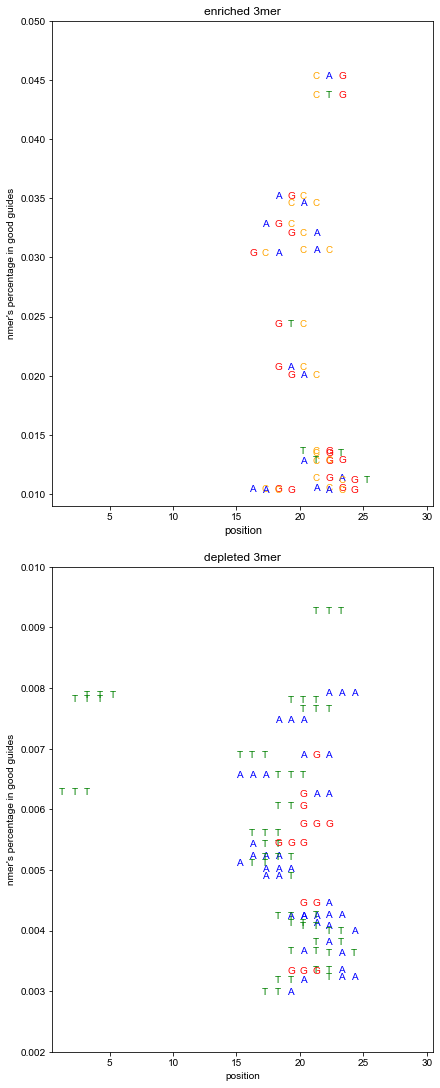

In [7]:
dic_all_enrich = {} # key is tuple of (pos,nmer), value is percent in good guides
dic_all_deplete = {} 

pos_nmer_enrich_dic = {} #key is pos, value is the list of distinguishing nmer at this pos
pos_nmer_deplete_dic = {}

nmer_pos_enrich_dic = {} #key is nmer, value is the list of pos where this nmer is enriched
nmer_pos_deplete_dic = {}

pos_base= ['A','C','T','G']
colors = ['blue','orange','green','red']

#plt.style.use('seaborn-whitegrid')
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
fig, ax = plt.subplots(2,1,figsize=(6,15),constrained_layout=True)

#average across all folds and plot
for i in range(len(nmer_list)): #nmer index
    for j in range(30-nmer_size+1): #pos
        if len(enriched_nmer_set_allf[i,j]) == 9: #distinguishing across all folds
            enriched_nmer_set_allf[i,j] = sum(enriched_nmer_set_allf[i,j])/9
            enriched_nmer_goodg_pct[i,j] = sum(enriched_nmer_goodg_pct[i,j])/9
            if j in pos_nmer_enrich_dic.keys():
                pos_nmer_enrich_dic[j].append(nmer_list[i])
            else:
                pos_nmer_enrich_dic[j]= [nmer_list[i]]
            nmer = nmer_list[i]
            if nmer in nmer_pos_enrich_dic:
                nmer_pos_enrich_dic[nmer].append(j)
            else:
                nmer_pos_enrich_dic[nmer]=[j]
            dic_all_enrich[(j,nmer)] = enriched_nmer_goodg_pct[i,j]
                                                                        
            #ax[0].scatter(j+1,enriched_nmer_set_allf[i,j],marker='.')
            #ax[0].scatter(j+1,enriched_nmer_goodg_pct[i,j],marker='.')
            for k in range(nmer_size):
                ax[0].annotate(nmer[k],(j+1+k,enriched_nmer_goodg_pct[i,j]),color=colors[pos_base.index(nmer[k])])
            #ax[0].annotate(nmer, # text
            #         #(j+1,enriched_nmer_set_allf[i,j]), # the point to label
            #        (j+1,enriched_nmer_goodg_pct[i,j]), # the point to label
            #         fontsize= 15, textcoords="offset points", # how to position the text
            #         xytext=(0,5), # distance from text to points
            #         ha='center') # horizontal alignment can be left, right or center
            #ax[0].set_ylabel("ratio of nmer's percentage in good guide to non-good guide")
            ax[0].set_ylabel("nmer's percentage in good guides")
            #ax[0].yscale('log',basey=2)
            ax[0].set_xlabel('position',fontsize= 11)
            ax[0].set_xlim(0.5,30.5)
            ax[0].set_ylim(0.009,0.05)
            ax[0].set_title('enriched 3mer')
            
        if len(depleted_nmer_set_allf[i,j]) == 9:
            depleted_nmer_set_allf[i,j] = sum(depleted_nmer_set_allf[i,j])/9
            depleted_nmer_goodg_pct[i,j] = sum(depleted_nmer_goodg_pct[i,j])/9
            if j in pos_nmer_deplete_dic.keys():
                pos_nmer_deplete_dic[j].append(nmer_list[i])
            else:
                pos_nmer_deplete_dic[j]=[nmer_list[i]]
            nmer = nmer_list[i]
            if nmer in nmer_pos_deplete_dic:
                nmer_pos_deplete_dic[nmer].append(j)
            else:
                nmer_pos_deplete_dic[nmer]=[j]
            dic_all_deplete[(j,nmer)] = depleted_nmer_goodg_pct[i,j]
                                          
            for k in range(nmer_size):
                ax[1].annotate(nmer[k],(j+1+k,depleted_nmer_goodg_pct[i,j]),color=colors[pos_base.index(nmer[k])])
            #ax[1].scatter(j+1,depleted_nmer_set_allf[i,j],marker='.')
            #ax[1].scatter(j+1,depleted_nmer_goodg_pct[i,j],marker='.')
            #ax[1].annotate(nmer, # text
            #         #(j+1,depleted_nmer_set_allf[i,j]), # the point to label
            #         (j+1,depleted_nmer_goodg_pct[i,j]), # the point to label
            #         fontsize= 15,textcoords="offset points", # how to position the text
            #         xytext=(0,5), # distance from text to points
            #         ha='center') # horizontal alignment can be left, right or center
            #ax[1].set_ylabel("ratio of nmer's percentage in good guide to non-good guide - log2")
            ax[1].set_ylabel("nmer's percentage in good guides")
            #ax[1].set_yscale('log',basey=2)
            ax[1].set_xlabel('position')
            ax[1].set_xlim(0.5,30.5)
            ax[1].set_ylim(0.002,0.01)
            ax[1].set_title('depleted 3mer')
            
#plt.savefig('a_figures/nmer_pos_specific_goodg_pct'+str(nmer_size)+'.svg', format="svg")

### sort and stack nmers by their percent in good guides

<Figure size 432x288 with 0 Axes>

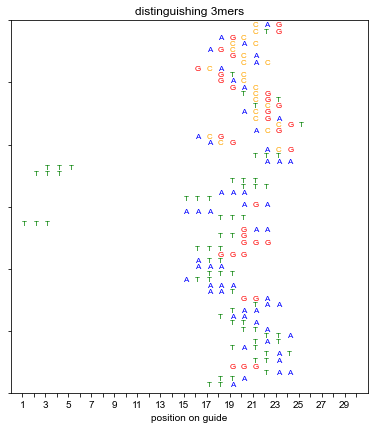

In [20]:
# integrate enriched nmers and depleted nmers
plt.clf()
fig,ax = plt.subplots(figsize=(6.4, 6.85))

dic_all_deplete_sort = dict(sorted(dic_all_deplete.items(), key=lambda item: item[1]))
depletemer_num = 0
for key in dic_all_deplete_sort:
    pos = key[0]
    nmer = key[1]
    depletemer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,depletemer_num),color=colors[pos_base.index(nmer[k])],fontsize=8)

dic_all_enrich_sort = dict(sorted(dic_all_enrich.items(), key=lambda item: item[1]))
enrichmer_num = 0
for key in dic_all_enrich_sort:
    pos = key[0]
    nmer = key[1]
    enrichmer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,enrichmer_num+depletemer_num),color=colors[pos_base.index(nmer[k])],fontsize=8)
            
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,60)
ax.set_yticklabels([])
ax.set_title('distinguishing 3mers')
#plt.show()
plt.savefig('../a_figures/nmer_pos_specific_nmer_summary_all_'+str(nmer_size)+'_mer.svg', format="svg")

<Figure size 432x288 with 0 Axes>

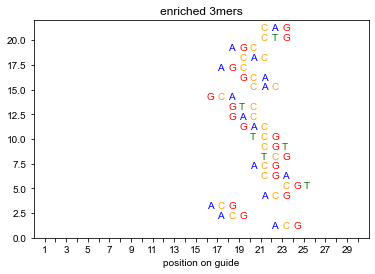

In [9]:
#enriched nmer
plt.clf()
fig,ax = plt.subplots()

dic_all_enrich_sort = dict(sorted(dic_all_enrich.items(), key=lambda item: item[1]))
enrichmer_num = 0
for key in dic_all_enrich_sort:
    pos = key[0]
    nmer = key[1]
    enrichmer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,enrichmer_num),color=colors[pos_base.index(nmer[k])])
        
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,22)
#ax.set_yticks([])
ax.set_title('enriched 3mers')
#plt.show()
plt.savefig('../a_figures/nmer_pos_specific_nmer_summary_enriched_'+str(nmer_size)+'_mer.svg', format="svg")

<Figure size 432x288 with 0 Axes>

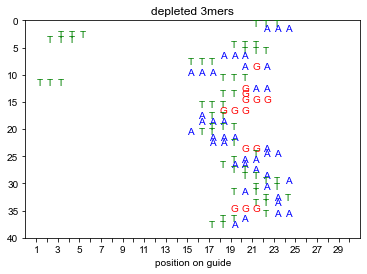

In [12]:
# depleted
plt.clf()
fig,ax = plt.subplots()

dic_all_deplete_sort = dict(sorted(dic_all_deplete.items(), key=lambda item: item[1],reverse=True))
depletemer_num = 0
for key in dic_all_deplete_sort:
    pos = key[0]
    nmer = key[1]
    depletemer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,depletemer_num),color=colors[pos_base.index(nmer[k])])
        
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,40)
#ax.set_yticks([])
ax.invert_yaxis()
ax.set_title('depleted 3mers')
#plt.show()
plt.savefig('../a_figures/nmer_pos_specific_nmer_summary_depleted_'+str(nmer_size)+'_mer.svg', format="svg")

In [13]:
#calculate nmer count for all guides
guide_enrichnmer_pos_num = 0
guide_depletemer_pos_num = 0
nmer_count = np.zeros((2, num_examples))
for i in range(num_examples):
    guide = dataframe['guide'].values[i]
    for p in pos_nmer_enrich_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_enrich_dic[p]:
            nmer_count[0,i] += 1 # enrichmer's count+1
    if nmer_count[0,i]>0: #contain any distinguishing nmer
        guide_enrichnmer_pos_num += 1
    for p in pos_nmer_deplete_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_deplete_dic[p]:
            nmer_count[1,i] += 1 # depletenmer's count+1
    if nmer_count[1,i]>0: #contain any distinguishing nmer
        guide_depletemer_pos_num += 1
            
print('guide with enrichmer percent: '+str(100*guide_enrichnmer_pos_num/num_examples))
print('guide with depletemer percent: '+str(100*guide_depletemer_pos_num/num_examples))

guide with enrichmer percent: 20.373704972403456
guide with depletemer percent: 40.57906682635533


Text(0.5, 1.0, 'differences of positional base count in enriched to depleted nmers')

<Figure size 432x288 with 0 Axes>

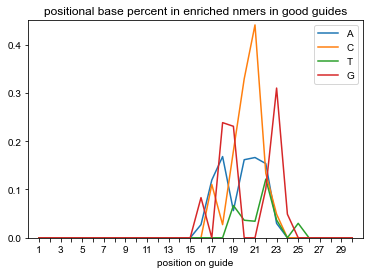

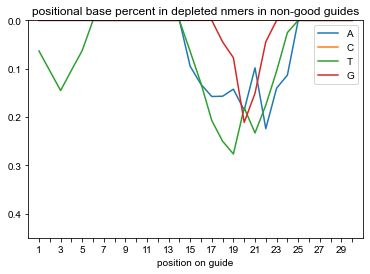

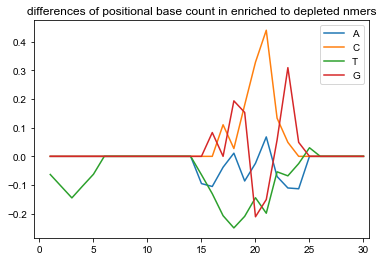

In [24]:
# summarize positional base percent from enriched/depleted nmers for good/non-good guides
goodg_df = dataframe[dataframe['binary_relative_ratio_075f']==1]
no_goodg_df = dataframe[dataframe['binary_relative_ratio_075f']==0]

enriched_nmer_base = np.zeros((4, 30))
depleted_nmer_base = np.zeros((4, 30))

# good guides
goodg_enrichmer_count = 0 # good guide number with any enriched nmers
for i in range(len(goodg_df)):
    guide = goodg_df['guide'].values[i]
    guide_enrichmer_flag = 0
    # enriched nmers
    guide_enrich_base = np.zeros((4, 30)) # flag of whether the positional base is in enriched nmers
    for p in pos_nmer_enrich_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_enrich_dic[p]:
            guide_enrichmer_flag = 1
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_enrich_base[0,p+k] = 1  
                if g_nmer[k].upper()=='C':
                    guide_enrich_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_enrich_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_enrich_base[3,p+k] = 1
    if guide_enrichmer_flag == 1:
        goodg_enrichmer_count += 1
        enriched_nmer_base = enriched_nmer_base + guide_enrich_base
    
# non-good guides 
nogoodg_depletemer_count = 0
for i in range(len(no_goodg_df)):
    guide = no_goodg_df['guide'].values[i]
    guide_depletemer_flag = 0
    # depleted nmers
    guide_deplete_base = np.zeros((4, 30)) # flag of whether the positional base is in depleted nmers
    for p in pos_nmer_deplete_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_deplete_dic[p]:
            guide_depletemer_flag = 1
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_deplete_base[0,p+k] = 1
                if g_nmer[k].upper()=='C':
                    guide_deplete_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_deplete_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_deplete_base[3,p+k] = 1
    if guide_depletemer_flag == 1:
        nogoodg_depletemer_count += 1
        depleted_nmer_base = depleted_nmer_base + guide_deplete_base

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111) 
pos_base= ['A','C','T','G']
# norm by the number of good guides with enriched nmers
enriched_nmer_base_norm = enriched_nmer_base/goodg_enrichmer_count
for pi in range(4):
    ax.plot(list(range(1, 31)),enriched_nmer_base_norm[pi,:],label=pos_base[pi])
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
ax.set_ylim(0,0.45)
ax.set_yticks(np.arange(0,0.45,0.1))
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.legend()
plt.title('positional base percent in enriched nmers in good guides')
plt.savefig('../a_figures/nmer_pos_specific_base_summary_enriched_'+str(nmer_size)+'_mer.svg', format="svg")

# norm by the number of non-good guides with depleted nmers
depleted_nmer_base_norm = depleted_nmer_base/nogoodg_depletemer_count
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    ax.plot(list(range(1, 31)),depleted_nmer_base_norm[pi,:],label=pos_base[pi])
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
ax.set_ylim(0,0.45)
ax.set_yticks(np.arange(0,0.45,0.1))
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.invert_yaxis()
plt.legend()
plt.title('positional base percent in depleted nmers in non-good guides')
plt.savefig('../a_figures/nmer_pos_specific_base_summary_depleted_'+str(nmer_size)+'_mer.svg', format="svg")

# substraction
#delta_enrich_deplete = enriched_nmer_base - depleted_nmer_base
delta_enrich_deplete = enriched_nmer_base_norm - depleted_nmer_base_norm
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    plt.plot(list(range(1, 31)),delta_enrich_deplete[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()
plt.title('differences of positional base count in enriched to depleted nmers')


<ipython-input-8-1e5c03f8830a>:73: RuntimeWarning: divide by zero encountered in true_divide
  ratio_enrich_deplete = enriched_nmer_base_norm / depleted_nmer_base_norm
<ipython-input-8-1e5c03f8830a>:73: RuntimeWarning: invalid value encountered in true_divide
  ratio_enrich_deplete = enriched_nmer_base_norm / depleted_nmer_base_norm


Text(0.5, 1.0, 'ratio of positional base percent in enriched to depleted nmers')

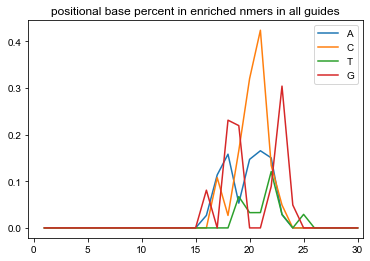

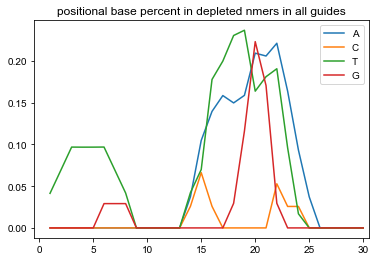

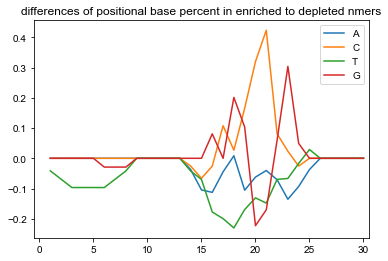

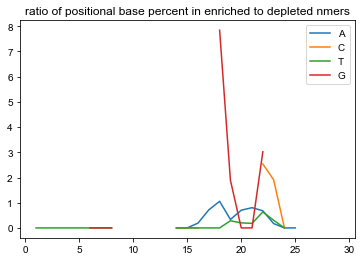

In [8]:
# summarize positional base from enriched/depleted nmers for all guides
enriched_nmer_base = np.zeros((4, 30))
depleted_nmer_base = np.zeros((4, 30))

for i in range(num_examples):
    guide = dataframe['guide'].values[i]
    # enriched nmers
    guide_enrich_base = np.zeros((4, 30)) # flag of whether the positional base is in enriched nmers
    for p in pos_nmer_enrich_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_enrich_dic[p]:
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_enrich_base[0,p+k] = 1  
                if g_nmer[k].upper()=='C':
                    guide_enrich_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_enrich_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_enrich_base[3,p+k] = 1
    enriched_nmer_base = enriched_nmer_base + guide_enrich_base
    # depleted nmers
    guide_deplete_base = np.zeros((4, 30)) # flag of whether the positional base is in depleted nmers
    for p in pos_nmer_deplete_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_deplete_dic[p]:
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_deplete_base[0,p+k] = 1
                if g_nmer[k].upper()=='C':
                    guide_deplete_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_deplete_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_deplete_base[3,p+k] = 1
    depleted_nmer_base = depleted_nmer_base + guide_deplete_base
    
# enriched nmer base, normed by guide number with enriched nmers
enriched_nmer_base_norm = enriched_nmer_base/guide_enrichnmer_pos_num
fig = plt.figure()
ax = fig.add_subplot(111) 
pos_base= ['A','C','T','G']
for pi in range(4):
    ax.plot(list(range(1, 31)),enriched_nmer_base_norm[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()
plt.title('positional base percent in enriched nmers in all guides')


# depleted nmer base, normed by guide number with depleted nmers
depleted_nmer_base_norm = depleted_nmer_base/guide_depletemer_pos_num
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    ax.plot(list(range(1, 31)),depleted_nmer_base_norm[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()
ax.invert_yaxis()
plt.title('positional base percent in depleted nmers in all guides')

# substraction
#delta_enrich_deplete = enriched_nmer_base - depleted_nmer_base
delta_enrich_deplete = enriched_nmer_base_norm - depleted_nmer_base_norm
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    plt.plot(list(range(1, 31)),delta_enrich_deplete[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()
plt.title('differences of positional base percent in enriched to depleted nmers')

In [28]:
#write results into file
with open('nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_enrichm.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for p in sorted(pos_nmer_enrich_dic.keys()):
        mywriter.writerow([p] + pos_nmer_enrich_dic[p])

with open('nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_depletem.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for p in sorted(pos_nmer_deplete_dic.keys()):
        mywriter.writerow([p] + pos_nmer_deplete_dic[p])

with open('nmer_results/'+'positional_new_kfold_nmer_index_nmer'+str(nmer_size) + '_enrichm.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for nm in nmer_pos_enrich_dic.keys():
        mywriter.writerow([nm] + nmer_pos_enrich_dic[nm])

with open('nmer_results/'+'positional_new_kfold_nmer_index_nmer'+str(nmer_size) + '_depletem.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for nm in nmer_pos_deplete_dic.keys():
        mywriter.writerow([nm] + nmer_pos_deplete_dic[nm])

In [29]:
#new version with positional base
inf = 'nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_enrichm.csv'
nmer_pos_dic = {}
with open(inf, mode='r') as infile:   
    reader = csv.reader(infile)
    nmer_pos_dic = {rows[0]:rows[1:] for rows in reader} #dicitonary with pos and nmer

pos_base_list = []
for pos in nmer_pos_dic.keys():
    nmer_list_p = nmer_pos_dic[pos]
    base_list_init = [''] *int(pos)
    for nmer in nmer_list_p:
        base_list_p = base_list_init + list(nmer)
        pos_base_list.append(base_list_p)
    
outf = 'nmer_results/positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_perbase_enrichm.csv'    
with open(outf,'w') as csvfile:
    mywriter = csv.writer(csvfile)
    mywriter.writerow(list(range(1, 31)))
    for i in pos_base_list:
        mywriter.writerow(i)
        
inf = 'nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_depletem.csv'
nmer_pos_dic = {}
with open(inf, mode='r') as infile:   
    reader = csv.reader(infile)
    nmer_pos_dic = {rows[0]:rows[1:] for rows in reader} #dicitonary with pos and nmer

pos_base_list = []
for pos in nmer_pos_dic.keys():
    nmer_list_p = nmer_pos_dic[pos]
    base_list_init = [''] *int(pos)
    for nmer in nmer_list_p:
        base_list_p = base_list_init + list(nmer)
        pos_base_list.append(base_list_p)
    
outf = 'nmer_results/positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_perbase_depletem.csv'    
with open(outf,'w') as csvfile:
    mywriter = csv.writer(csvfile)
    mywriter.writerow(list(range(1, 31)))
    for i in pos_base_list:
        mywriter.writerow(i)

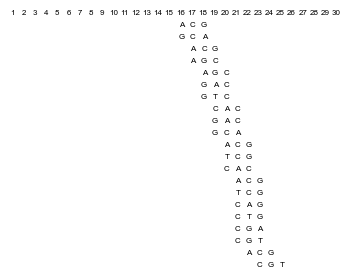

In [12]:
# plot stacked nmers from the table, enriched
inf = 'nmer_results/positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_perbase_enrichm.csv'   

table = pd.read_csv(inf,index_col=False)
table = table.fillna("")

plt.figure()
# table
plt.subplot(111)
cell_text = []
for row in range(len(table)):
    cell_text.append(table.iloc[row])
plt.table(cellText=cell_text, colLabels=table.columns, loc='center',edges='open')
plt.axis('off')
plt.show()

<Figure size 432x288 with 0 Axes>

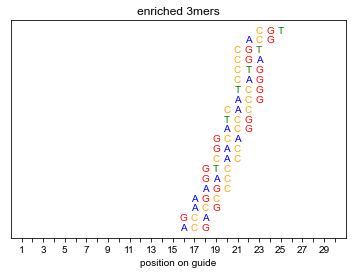

In [15]:
plt.clf()
fig,ax = plt.subplots()
#yv = 0
for p in range(1,31):
    b_list = table[str(p)].values
    i = 0
    for bb in b_list:
        i += 1
        if bb != '':
            #yv += 1
            ax.annotate(bb,(p,i),ha='center', va='center',color=colors[pos_base.index(bb)])

x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,22)
ax.set_yticks([])
ax.set_title('enriched 3mers')
#plt.show()
plt.savefig('a_figures/nmer_pos_specific_nmer_summary_enriched_'+str(nmer_size)+'_mer.svg', format="svg")

In [31]:
# plot stacked nmers from the table, depleted
inf = 'nmer_results/positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_perbase_depletem.csv'   
table = pd.read_csv(inf,index_col=False)
table = table.fillna("")

fig,ax = plt.subplots()
for p in range(1,31):
    b_list = table[str(p)].values
    i = 0
    for bb in b_list:
        i += 1
        if bb != '':
            ax.annotate(bb,(p,i),ha='center', va='center',color=colors[pos_base.index(bb)])

x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,76)
ax.set_yticks([])
ax.set_title('depleted 3mers')
plt.show()
#plt.savefig('a_figures/nmer_pos_specific_nmer_summary_depleted_'+str(nmer_size)+'_mer.svg', format="svg")

ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.


<ipython-input-7-3af5574f6794>:2: RuntimeWarning: invalid value encountered in true_divide
  enriched_nmer_base_weighted_ratio = enriched_nmer_base_weighted_ratio/np.sum(enriched_nmer_base_weighted_ratio, axis=0) #normalize


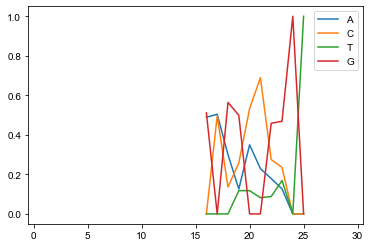

In [7]:
# weighted positional base importance from enriched nmers' ratio
enriched_nmer_base_weighted_ratio = enriched_nmer_base_weighted_ratio/np.sum(enriched_nmer_base_weighted_ratio, axis=0) #normalize

pos_base= ['A','C','T','G']
for pi in range(4):
    plt.plot(list(range(1, 31)),enriched_nmer_base_weighted_ratio[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()

<ipython-input-8-c8defa694186>:2: RuntimeWarning: invalid value encountered in true_divide
  enriched_nmer_base_weighted_goodpct = enriched_nmer_base_weighted_goodpct/np.sum(enriched_nmer_base_weighted_goodpct, axis=0) #normalize


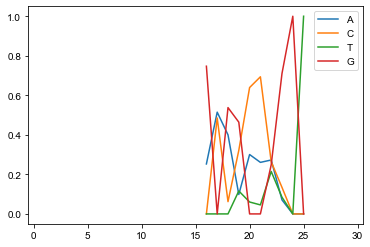

In [8]:
# weighted positional base importance from enriched nmers' percent in good guides
enriched_nmer_base_weighted_goodpct = enriched_nmer_base_weighted_goodpct/np.sum(enriched_nmer_base_weighted_goodpct, axis=0) #normalize
for pi in range(4):
    plt.plot(list(range(1, 31)),enriched_nmer_base_weighted_goodpct[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()

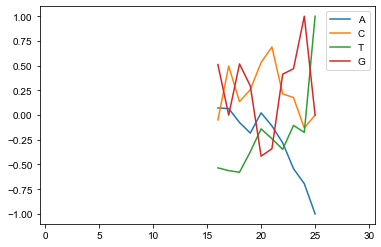

In [22]:
delta_enrich_deplete = enriched_nmer_base - depleted_nmer_base
for pi in range(4):
    plt.plot(list(range(1, 31)),delta_enrich_deplete[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()

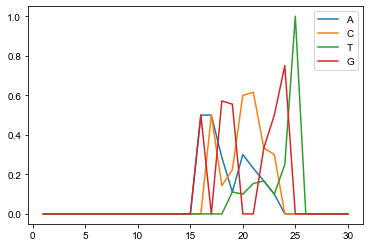

In [8]:
# unweighted positional base importance from the table
inf = 'nmer_results/positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_perbase_enrichm.csv'   
enriched_nmer_base = np.zeros((4, 30)) 
depleted_nmer_base = np.zeros((4, 30)) 
df_pos = pd.read_csv(inf,index_col=False)

pos_base= ['A','C','T','G']
for p in range(1, 31):
    base_pos = list(df_pos[str(p)].values)
    base_pos = [x for x in base_pos if pd.isnull(x) == False]
    if len(base_pos)>0:
        for b in pos_base:
            enriched_nmer_base[pos_base.index(b),p-1] = base_pos.count(b)/len(base_pos)
    
for pi in range(4):
    plt.plot(list(range(1, 31)),enriched_nmer_base[pi,:],label=pos_base[pi])
plt.legend()


## 4mer

In [5]:
nmer_size = 4
nmer_list =[]
#generate all nmer list
for b1 in base_list:
    for b2 in base_list:
        for b3 in base_list:
            for b4 in base_list:
                nmer = b1+b2+b3+b4
                nmer_list.append(nmer)
len(nmer_list)

256

In [6]:
# 4 mer
enrich_cut = 2.3
deplete_cut = 0.3
#enrich_cut = 2.5
#deplete_cut = 0.4
enriched_nmer_set_allf = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object) # entry:list of ratio for all folds
depleted_nmer_set_allf = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object)
enriched_nmer_goodg_pct = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object) # entry:list of percent in good guides for all folds
depleted_nmer_goodg_pct = np.empty((len(nmer_list), (30-nmer_size+1)),dtype=object)
for i in range(len(nmer_list)): #nmer index
    for j in range(30-nmer_size+1): #pos
        enriched_nmer_set_allf[i,j]=[]
        depleted_nmer_set_allf[i,j]=[]
        enriched_nmer_goodg_pct[i,j]=[]
        depleted_nmer_goodg_pct[i,j]=[]
        
for s in range(9): # k fold split
    tr, te = create_gene_splits_filter1_kfold_noval(dataframe['gene'].values, all_cols, 9, s)

    #training set
    goodguide_num = 0
    badguide_num = 0
    nmer_count_goodg = np.zeros((len(nmer_list), (30-nmer_size+1)))
    nmer_count_badg = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(tr[0])):
        g = tr[0][i] #guideseq
        b_ratio  = tr[1][i]
        if b_ratio == 1: # good depleted guides
            goodguide_num += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_goodg[gm_index,p] += 1 # count in good guides
        else: # non-good guides
            badguide_num += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_badg[gm_index,p] += 1 # count in non-good guides
            
    # calculate nmer percentage
    nmer_count_all_guides = np.add(nmer_count_goodg, nmer_count_badg) # nmer count for all guides
    nmer_count_goodg = (nmer_count_goodg+0.01)/goodguide_num # normalize by the total nmer count at a position
    nmer_count_badg = (nmer_count_badg+0.01)/badguide_num
    
    # good vs bad guide nmer ratio
    nmer_count_ratio = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_all_guides[i,j]<= 4: # nmer not enough representation, set ratio as -1
                nmer_count_ratio[i,j]= -1
            else:
                nmer_count_ratio[i,j]= nmer_count_goodg[i,j]/nmer_count_badg[i,j]

    # test set analysis
    goodguide_num_test = 0
    badguide_num_test = 0
    nmer_count_goodg_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    nmer_count_badg_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(te[0])):
        g = te[0][i]
        b_ratio = te[1][i]
        if b_ratio == 1: # good depleted guides
            goodguide_num_test += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_goodg_test[gm_index,p] += 1 # count in good guides
        else: # non-good guides
            badguide_num_test += 1
            for p in range(30-nmer_size+1):
                gm = g[p:(nmer_size+p)] # nmer at position p
                gm_index = nmer_list.index(gm)
                nmer_count_badg_test[gm_index,p] += 1 # count in non-good guides
                
    # calculate nmer percentage
    nmer_count_all_guides_test = np.add(nmer_count_goodg_test, nmer_count_badg_test) # nmer count for all guides
    nmer_count_goodg_test = (nmer_count_goodg_test+0.01)/goodguide_num_test # normalize by the total nmer count at a position
    nmer_count_badg_test = (nmer_count_badg_test+0.01)/badguide_num_test
    
    # good vs bad guide nmer ratio
    nmer_count_ratio_test = np.zeros((len(nmer_list), (30-nmer_size+1)))
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_all_guides_test[i,j]<= 4: #nmer not enough representation, set ratio as -1
                nmer_count_ratio_test[i,j]= -1
            else:
                nmer_count_ratio_test[i,j]= nmer_count_goodg_test[i,j]/nmer_count_badg_test[i,j]
                
    # find distinguishing nmers from the training set!
    for i in range(len(nmer_list)):
        for j in range(30-nmer_size+1):
            if nmer_count_ratio[i,j]!= -1:
                if (nmer_count_ratio[i,j]> enrich_cut) and (nmer_count_ratio_test[i,j]!= -1): # enriched
                    if enriched_nmer_set_allf[i,j]==[]:
                        enriched_nmer_set_allf[i,j]=[nmer_count_ratio_test[i,j]]
                    else:
                        enriched_nmer_set_allf[i,j].append(nmer_count_ratio_test[i,j])
                    if enriched_nmer_goodg_pct[i,j]==[]:
                        enriched_nmer_goodg_pct[i,j]= [nmer_count_goodg_test[i,j]]
                    else:
                        enriched_nmer_goodg_pct[i,j].append(nmer_count_goodg_test[i,j])                      
                if (nmer_count_ratio[i,j]< deplete_cut) and (nmer_count_ratio_test[i,j]!= -1): # depleted
                    if depleted_nmer_set_allf[i,j]==[]:
                        depleted_nmer_set_allf[i,j]=[nmer_count_ratio_test[i,j]]
                    else:
                        depleted_nmer_set_allf[i,j].append(nmer_count_ratio_test[i,j])
                    if depleted_nmer_goodg_pct[i,j]==[]:
                        depleted_nmer_goodg_pct[i,j]= [nmer_count_goodg_test[i,j]]
                    else:
                        depleted_nmer_goodg_pct[i,j].append(nmer_count_goodg_test[i,j])
                        

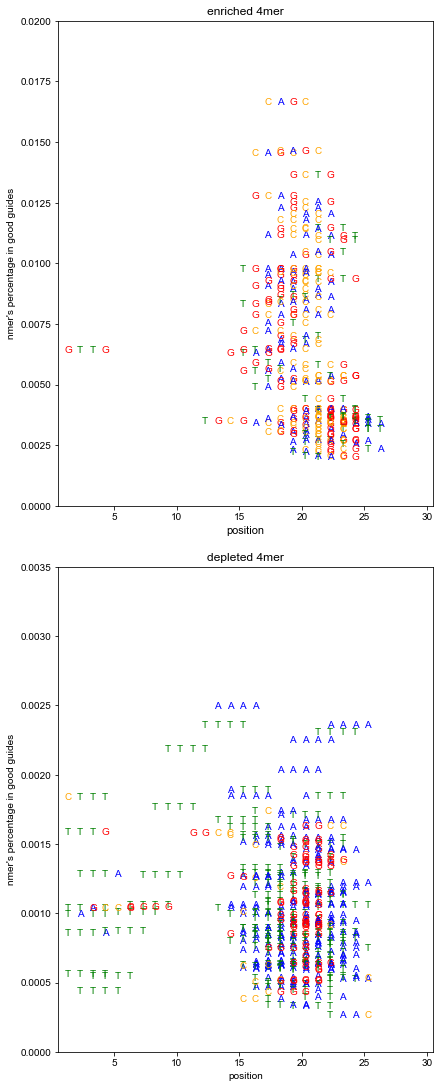

In [7]:
dic_all_enrich = {} # key is tuple of (pos,nmer), value is percent in good guides
dic_all_deplete = {} 

pos_nmer_enrich_dic = {} #key is pos, value is the list of distinguishing nmer at this pos
pos_nmer_deplete_dic = {}

nmer_pos_enrich_dic = {} #key is nmer, value is the list of pos where this nmer is enriched
nmer_pos_deplete_dic = {}

pos_base= ['A','C','T','G']
colors = ['blue','orange','green','red']

#plt.style.use('seaborn-whitegrid')
plt.rcParams['svg.fonttype'] = 'none'
# change font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
fig, ax = plt.subplots(2,1,figsize=(6,15),constrained_layout=True)

#average across all folds and plot
for i in range(len(nmer_list)): #nmer index
    for j in range(30-nmer_size+1): #pos
        if len(enriched_nmer_set_allf[i,j]) == 9: #distinguishing across all folds
            enriched_nmer_set_allf[i,j] = sum(enriched_nmer_set_allf[i,j])/9
            enriched_nmer_goodg_pct[i,j] = sum(enriched_nmer_goodg_pct[i,j])/9
            if j in pos_nmer_enrich_dic.keys():
                pos_nmer_enrich_dic[j].append(nmer_list[i])
            else:
                pos_nmer_enrich_dic[j]= [nmer_list[i]]
            nmer = nmer_list[i]
            if nmer in nmer_pos_enrich_dic:
                nmer_pos_enrich_dic[nmer].append(j)
            else:
                nmer_pos_enrich_dic[nmer]=[j]
            dic_all_enrich[(j,nmer)] = enriched_nmer_goodg_pct[i,j]
                                                                        
            #ax[0].scatter(j+1,enriched_nmer_set_allf[i,j],marker='.')
            #ax[0].scatter(j+1,enriched_nmer_goodg_pct[i,j],marker='.')
            for k in range(nmer_size):
                ax[0].annotate(nmer[k],(j+1+k,enriched_nmer_goodg_pct[i,j]),color=colors[pos_base.index(nmer[k])])
            #ax[0].annotate(nmer, # text
            #         #(j+1,enriched_nmer_set_allf[i,j]), # the point to label
            #        (j+1,enriched_nmer_goodg_pct[i,j]), # the point to label
            #         fontsize= 15, textcoords="offset points", # how to position the text
            #         xytext=(0,5), # distance from text to points
            #         ha='center') # horizontal alignment can be left, right or center
            #ax[0].set_ylabel("ratio of nmer's percentage in good guide to non-good guide")
            ax[0].set_ylabel("nmer's percentage in good guides")
            #ax[0].yscale('log',basey=2)
            ax[0].set_xlabel('position',fontsize= 11)
            ax[0].set_xlim(0.5,30.5)
            ax[0].set_ylim(0,0.02)
            ax[0].set_title('enriched 4mer')
            
        if len(depleted_nmer_set_allf[i,j]) == 9:
            depleted_nmer_set_allf[i,j] = sum(depleted_nmer_set_allf[i,j])/9
            depleted_nmer_goodg_pct[i,j] = sum(depleted_nmer_goodg_pct[i,j])/9
            if j in pos_nmer_deplete_dic.keys():
                pos_nmer_deplete_dic[j].append(nmer_list[i])
            else:
                pos_nmer_deplete_dic[j]=[nmer_list[i]]
            nmer = nmer_list[i]
            if nmer in nmer_pos_deplete_dic:
                nmer_pos_deplete_dic[nmer].append(j)
            else:
                nmer_pos_deplete_dic[nmer]=[j]
            dic_all_deplete[(j,nmer)] = depleted_nmer_goodg_pct[i,j]
                                          
            for k in range(nmer_size):
                ax[1].annotate(nmer[k],(j+1+k,depleted_nmer_goodg_pct[i,j]),color=colors[pos_base.index(nmer[k])])
            #ax[1].scatter(j+1,depleted_nmer_set_allf[i,j],marker='.')
            #ax[1].scatter(j+1,depleted_nmer_goodg_pct[i,j],marker='.')
            #ax[1].annotate(nmer, # text
            #         #(j+1,depleted_nmer_set_allf[i,j]), # the point to label
            #         (j+1,depleted_nmer_goodg_pct[i,j]), # the point to label
            #         fontsize= 15,textcoords="offset points", # how to position the text
            #         xytext=(0,5), # distance from text to points
            #         ha='center') # horizontal alignment can be left, right or center
            #ax[1].set_ylabel("ratio of nmer's percentage in good guide to non-good guide - log2")
            ax[1].set_ylabel("nmer's percentage in good guides")
            #ax[1].set_yscale('log',basey=2)
            ax[1].set_xlabel('position')
            ax[1].set_xlim(0.5,30.5)
            ax[1].set_ylim(0,0.0035)
            ax[1].set_title('depleted 4mer')
            
#plt.savefig('a_figures/nmer_pos_specific_goodg_pct'+str(nmer_size)+'.svg', format="svg")

In [8]:
#calculate nmer count for all guides
guide_enrichnmer_pos_num = 0
guide_depletemer_pos_num = 0
nmer_count = np.zeros((2, num_examples))
for i in range(num_examples):
    guide = dataframe['guide'].values[i]
    for p in pos_nmer_enrich_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_enrich_dic[p]:
            nmer_count[0,i] += 1 # enrichmer's count+1
    if nmer_count[0,i]>0: #contain any distinguishing nmer
        guide_enrichnmer_pos_num += 1
    for p in pos_nmer_deplete_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_deplete_dic[p]:
            nmer_count[1,i] += 1 # depletenmer's count+1
    if nmer_count[1,i]>0: #contain any distinguishing nmer
        guide_depletemer_pos_num += 1
            
print('guide with enrichmer percent: '+str(100*guide_enrichnmer_pos_num/num_examples))
print('guide with depletemer percent: '+str(100*guide_depletemer_pos_num/num_examples))

guide with enrichmer percent: 19.693632274977176
guide with depletemer percent: 40.474375832293404


Text(0.5, 1.0, 'enriched 4mers')

<Figure size 432x288 with 0 Axes>

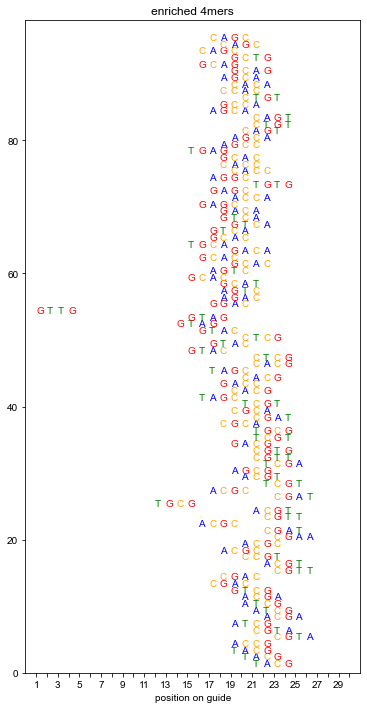

In [9]:
# sort and stack nmers by their percent in good guides
#enriched nmer
plt.clf()
fig,ax = plt.subplots(figsize=(6,12))

dic_all_enrich_sort = dict(sorted(dic_all_enrich.items(), key=lambda item: item[1]))
enrichmer_num = 0
for key in dic_all_enrich_sort:
    pos = key[0]
    nmer = key[1]
    enrichmer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,enrichmer_num),color=colors[pos_base.index(nmer[k])])
        
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,98)
#ax.set_yticks([])
ax.set_title('enriched 4mers')
#plt.show()
#plt.savefig('../a_figures/nmer_pos_specific_nmer_summary_enriched_'+str(nmer_size)+'_mer.svg', format="svg")

Text(0.5, 1.0, 'depleted 4mers')

<Figure size 432x288 with 0 Axes>

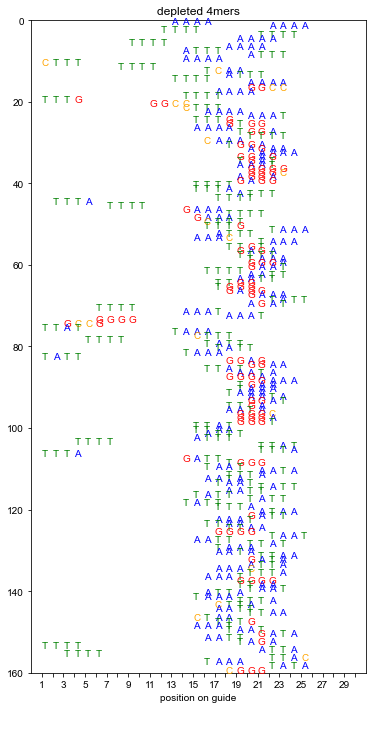

In [10]:
# depleted
plt.clf()
fig,ax = plt.subplots(figsize=(6,12))

dic_all_deplete_sort = dict(sorted(dic_all_deplete.items(), key=lambda item: item[1],reverse=True))
depletemer_num = 0
for key in dic_all_deplete_sort:
    pos = key[0]
    nmer = key[1]
    depletemer_num += 1
    for k in range(nmer_size):
        ax.annotate(nmer[k],(pos+1+k,depletemer_num),color=colors[pos_base.index(nmer[k])])
        
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,160)
#ax.set_yticks([])
ax.invert_yaxis()
ax.set_title('depleted 4mers')
#plt.show()
#plt.savefig('../a_figures/nmer_pos_specific_nmer_summary_depleted_'+str(nmer_size)+'_mer.svg', format="svg")

Text(0.5, 1.0, 'differences of positional base count in enriched to depleted nmers')

<Figure size 432x288 with 0 Axes>

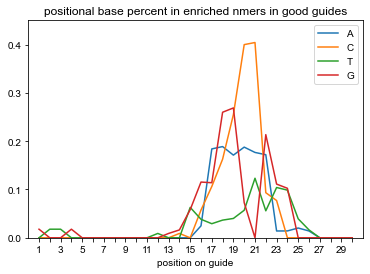

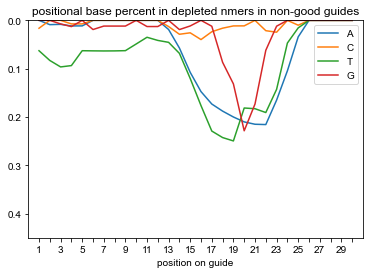

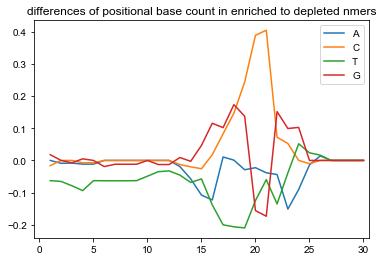

In [11]:
# summarize positional base percent from enriched/depleted nmers for good/non-good guides
goodg_df = dataframe[dataframe['binary_relative_ratio_075f']==1]
no_goodg_df = dataframe[dataframe['binary_relative_ratio_075f']==0]

enriched_nmer_base = np.zeros((4, 30))
depleted_nmer_base = np.zeros((4, 30))

# good guides
goodg_enrichmer_count = 0 # good guide number with any enriched nmers
for i in range(len(goodg_df)):
    guide = goodg_df['guide'].values[i]
    guide_enrichmer_flag = 0
    # enriched nmers
    guide_enrich_base = np.zeros((4, 30)) # flag of whether the positional base is in enriched nmers
    for p in pos_nmer_enrich_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_enrich_dic[p]:
            guide_enrichmer_flag = 1
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_enrich_base[0,p+k] = 1  
                if g_nmer[k].upper()=='C':
                    guide_enrich_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_enrich_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_enrich_base[3,p+k] = 1
    if guide_enrichmer_flag == 1:
        goodg_enrichmer_count += 1
        enriched_nmer_base = enriched_nmer_base + guide_enrich_base
    
# non-good guides 
nogoodg_depletemer_count = 0
for i in range(len(no_goodg_df)):
    guide = no_goodg_df['guide'].values[i]
    guide_depletemer_flag = 0
    # depleted nmers
    guide_deplete_base = np.zeros((4, 30)) # flag of whether the positional base is in depleted nmers
    for p in pos_nmer_deplete_dic.keys():
        g_nmer = guide[p:(nmer_size+p)]
        if g_nmer in pos_nmer_deplete_dic[p]:
            guide_depletemer_flag = 1
            for k in range(nmer_size):
                if g_nmer[k].upper()=='A':
                    guide_deplete_base[0,p+k] = 1
                if g_nmer[k].upper()=='C':
                    guide_deplete_base[1,p+k] = 1  
                if g_nmer[k].upper()=='T':
                    guide_deplete_base[2,p+k] = 1  
                if g_nmer[k].upper()=='G':
                    guide_deplete_base[3,p+k] = 1
    if guide_depletemer_flag == 1:
        nogoodg_depletemer_count += 1
        depleted_nmer_base = depleted_nmer_base + guide_deplete_base

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111) 
pos_base= ['A','C','T','G']
# norm by the number of good guides with enriched nmers
enriched_nmer_base_norm = enriched_nmer_base/goodg_enrichmer_count
for pi in range(4):
    ax.plot(list(range(1, 31)),enriched_nmer_base_norm[pi,:],label=pos_base[pi])
x1 = np.arange(1, 31)
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,0.45)
ax.set_yticks(np.arange(0,0.45,0.1))
plt.legend()
plt.title('positional base percent in enriched nmers in good guides')
plt.savefig('../a_figures/nmer_pos_specific_base_summary_enriched_'+str(nmer_size)+'_mer.svg', format="svg")

# norm by the number of non-good guides with depleted nmers
depleted_nmer_base_norm = depleted_nmer_base/nogoodg_depletemer_count
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    ax.plot(list(range(1, 31)),depleted_nmer_base_norm[pi,:],label=pos_base[pi])
ax.set_xticks(x1)
ax.set_xlabel('position on guide')
ax.set_xlim(0,31)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.set_ylim(0,0.45)
ax.set_yticks(np.arange(0,0.45,0.1))
ax.invert_yaxis()
plt.legend()
plt.title('positional base percent in depleted nmers in non-good guides')
plt.savefig('../a_figures/nmer_pos_specific_base_summary_depleted_'+str(nmer_size)+'_mer.svg', format="svg")

# substraction
#delta_enrich_deplete = enriched_nmer_base - depleted_nmer_base
delta_enrich_deplete = enriched_nmer_base_norm - depleted_nmer_base_norm
fig = plt.figure()
ax = fig.add_subplot(111) 
for pi in range(4):
    plt.plot(list(range(1, 31)),delta_enrich_deplete[pi,:],label=pos_base[pi])
plt.xlim(-0.5,30.5)
plt.legend()
plt.title('differences of positional base count in enriched to depleted nmers')

In [26]:
#write results into file
with open('nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_enrichm.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for p in sorted(pos_nmer_enrich_dic.keys()):
    #for p in pos_nmer_enrich_dic.keys():
        mywriter.writerow([p] + pos_nmer_enrich_dic[p])

with open('nmer_results/'+'positional_new_kfold_pos_index_nmer'+str(nmer_size) + '_depletem.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for p in sorted(pos_nmer_deplete_dic.keys()):
        mywriter.writerow([p] + pos_nmer_deplete_dic[p])

with open('nmer_results/'+'positional_new_kfold_nmer_index_nmer'+str(nmer_size) + '_enrichm.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for nm in nmer_pos_enrich_dic.keys():
        mywriter.writerow([nm] + nmer_pos_enrich_dic[nm])

with open('nmer_results/'+'positional_new_kfold_nmer_index_nmer'+str(nmer_size) + '_depletem.csv','w') as csvfile:
    mywriter = csv.writer(csvfile)
    for nm in nmer_pos_deplete_dic.keys():
        mywriter.writerow([nm] + nmer_pos_deplete_dic[nm])

In [27]:
#new version with positional base
inf = 'nmer_results/positional_new_kfold_pos_index_nmer4_enrichm.csv'
nmer_pos_dic = {}
with open(inf, mode='r') as infile:   
    reader = csv.reader(infile)
#    for row in reader:
#        guide_list.append(row[-1])
    nmer_pos_dic = {rows[0]:rows[1:] for rows in reader} #dicitonary with pos and nmer

pos_base_list = []
for pos in nmer_pos_dic.keys():
    nmer_list = nmer_pos_dic[pos]
    base_list_init = [''] *int(pos)
    #print(base_list_init)
    for nmer in nmer_list:
        base_list = base_list_init + list(nmer)
        pos_base_list.append(base_list)
    
outf = 'nmer_results/positional_new_kfold_pos_index_nmer4_perbase_enrichm.csv'    
with open(outf,'w') as csvfile:
    mywriter = csv.writer(csvfile)
    mywriter.writerow(list(range(1, 30)))
    for i in pos_base_list:
        mywriter.writerow(i)

In [7]:
nmer_pos_dic

{'0': ['GTTG'],
 '11': ['TGCG'],
 '13': ['GTAG'],
 '14': ['TGAG', 'TGCA', 'GTAC', 'GTAG', 'GCAC'],
 '15': ['ACGC', 'TAGC', 'CAGC', 'GAGC', 'GTAC', 'GCAC', 'GCAG'],
 '16': ['ACGC',
  'AGTC',
  'AGCA',
  'AGGC',
  'TAGC',
  'CAGC',
  'CGAC',
  'GAGC',
  'GTAC',
  'GTCA',
  'GCAC',
  'GGAC'],
 '17': ['ACGC',
  'AGAC',
  'AGTC',
  'AGCA',
  'AGCC',
  'CACC',
  'CAGC',
  'CCAC',
  'CGAC',
  'CGCA',
  'GACA',
  'GACC',
  'GTCA',
  'GCAT',
  'GCAC',
  'GCCA'],
 '18': ['ATCG',
  'ACCA',
  'ACCG',
  'AGCA',
  'AGCG',
  'TACG',
  'CACA',
  'CACC',
  'CACG',
  'CGCA',
  'GACA',
  'GACG',
  'GTCA',
  'GTCG',
  'GCAC',
  'GCAG',
  'GCTG'],
 '19': ['ATCG',
  'ACGA',
  'ACGT',
  'ACGC',
  'TACG',
  'TCGT',
  'CACG',
  'CAGT',
  'CTCG',
  'CTGT',
  'CCGT'],
 '20': ['ATCG',
  'ACGT',
  'TACG',
  'TCGT',
  'TGTG',
  'TGCG',
  'CACG',
  'CAGT',
  'CTCG',
  'CTGT',
  'CGAT',
  'CGTA',
  'CGTT',
  'CGTG'],
 '21': ['ACGA', 'ACGT', 'TCGA', 'TCGT', 'CGAT', 'CGTT'],
 '22': ['CGAA', 'CGAT', 'CGTA', 'CGTT']}